<a href="https://colab.research.google.com/github/AV-BOLT/Stars_temp_prediction/blob/master/%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование температуры звезды

Целевой признак - Temperature (K)

## Загрузка данных и библиотек

In [1]:
import pandas as pd
import re
import torch.nn as nn
import torch
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Projects_YP/нейронные сети 1 проект/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [3]:
data.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [4]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [5]:
RANDOM_STATE = 42

In [6]:
# Зададим константу для воспроизводимости результатов
torch.manual_seed(RANDOM_STATE)

In [7]:
np.random.seed(RANDOM_STATE)

In [8]:
# переименуем признаки
data.columns = ['temperature',
                'luminosity',
                'radius',
                'magnitude',
                'star_type',
                'star_color']

In [9]:
data.columns

Index(['temperature', 'luminosity', 'radius', 'magnitude', 'star_type',
       'star_color'],
      dtype='object')

## Исследовательский анализ

Проверим данные на типы данных и пропущенные значения.

In [10]:
data.shape

(240, 6)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


В данных отсутствуют пропущенные значения.

Присутствуют числовые и один признак категориальный.




Проанализируем категориальный признак

In [12]:
categorical = data.select_dtypes(include = 'object').columns.to_list()
categorical

['star_color']

В признаке имеются неявные дубликаты.
Необходимо:
- привести к строчному регистру
- заменить "-" на "_"
- удалить пробелы

In [13]:
def transform_values(df):

   #удаляем пробелы в конце строк
    df = df.applymap(lambda x: x.rstrip())
     # заменяем пробелы на underscore

    df = df.applymap(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

    # заменяем дефис на underscore
    df = df.applymap(lambda x: x.replace('-', '_') if isinstance(x, str) else x)

    # добавляем underscore между словом и числом
    df = df.applymap(lambda x: '_'.join(part for part in x.split() if not part.isdigit()) if isinstance(x, str) else x)

    # приводим к строчному регистру
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

In [14]:
data[categorical] = transform_values(data[categorical])
data[categorical]

,star_color
0,red
1,red
2,red
3,red
4,red
...,...
235,blue
236,blue
237,white
238,white


In [15]:
list(data['star_color'].sort_values().unique())

['blue',
 'blue_white',
 'orange',
 'orange_red',
 'pale_yellow_orange',
 'red',
 'white',
 'white_yellow',
 'whitish',
 'yellow_white',
 'yellowish',
 'yellowish_white']

Дубликаты удалены.

In [16]:
data['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

In [17]:
data.dtypes

temperature      int64
luminosity     float64
radius         float64
magnitude      float64
star_type        int64
star_color      object
dtype: object

In [18]:
data[['star_type','star_color' ]].value_counts(normalize = True)

star_type  star_color        
0          red                   0.166667
1          red                   0.166667
4          blue                  0.129167
5          red                   0.095833
3          blue_white            0.087500
2          blue_white            0.058333
           blue                  0.054167
4          red                   0.037500
2          white                 0.033333
3          yellow_white          0.033333
5          blue                  0.029167
           blue_white            0.025000
3          blue                  0.020833
2          yellowish_white       0.012500
3          yellowish             0.012500
5          orange                0.008333
           white                 0.008333
3          whitish               0.008333
2          white_yellow          0.004167
           pale_yellow_orange    0.004167
3          orange_red            0.004167
dtype: float64

## Анализ числовых признаков

In [19]:
numerical = data.select_dtypes(include = ('int', 'float', 'bool')).columns.to_list()

In [20]:
numerical =['luminosity', 'radius', 'magnitude', 'star_type']

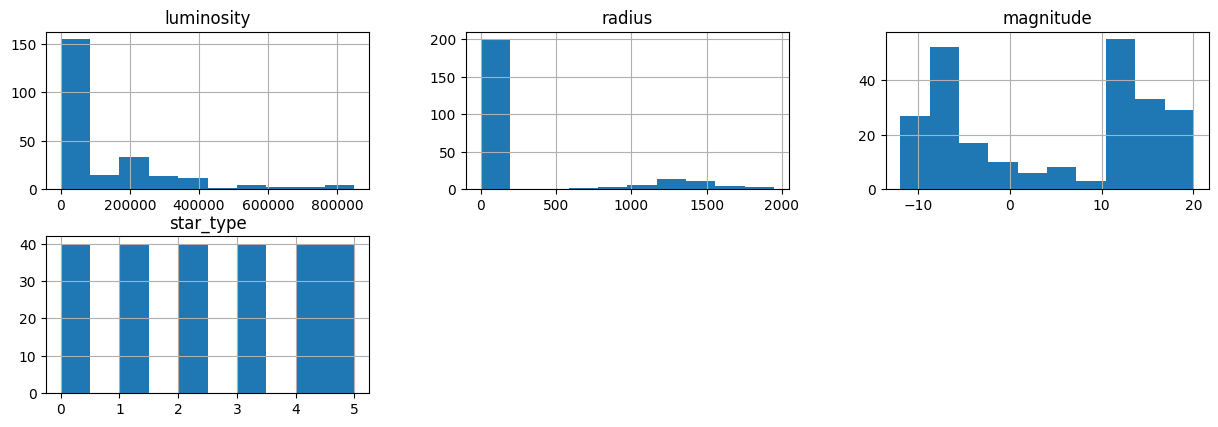

In [21]:
data[numerical].hist(layout = (4,3),
                     figsize=(15, 10));


Видим, что числовые значения имеют разный порядок, значит необходимо будет перед обучением подготовить признаки.

##Подготовка данных для модели

In [22]:
result = []

In [23]:
# функция для построения графика для результатов
def plot (y_test, test_outputs, name):

    #name это (название модели)

    fact_values = y_test.numpy().flatten()
    forecast_values = test_outputs.numpy().flatten()

    # в тестовом датасете 48 звезд, но дальше их может быть больше
    # поэтому ограничим
    indexes = test[y].index[:48]

    plt.figure(figsize=(8, 4))
    sns.set_style('ticks', {'axes.grid': True})

    # Создание столбчатой диаграммы для фактических значений
    fact_plot = sns.barplot(x = indexes,
                            y = fact_values,
                            color='blue',
                            alpha=0.9,
                            label='Факт')

    # Создание столбчатой диаграммы для прогнозов
    forecast_plot = sns.barplot(x=indexes,
                                y = forecast_values,
                                color='yellow',
                                alpha=0.7,
                                label='Прогноз')

    # Установка ширины столбцов и их позиции
    bar_width = 0.6

    for bar in fact_plot.patches + forecast_plot.patches:
        bar.set_width(bar_width)
        x = bar.get_x()
        bar.set_x(x + bar_width / 2)

    # Установка подписей осей и заголовка
    plt.xlabel('Номер звезды в таблице данных', fontweight='bold')

    plt.ylabel('Температура звезды', fontweight='bold')

    plt.title(f'{name}')

    plt.xticks(rotation=85)

    plt.yscale('log') # чтобы на графике можно
                       # было увидеть значения разных порядков

    # Создание и настройка легенды
    handles, labels = plt.gca().get_legend_handles_labels()

    handles.reverse()
    labels.reverse()
    plt.legend(handles,
               labels,
               bbox_to_anchor=(0.5, -0.25),
               loc='upper center',
               ncol=2)

    return plt.show()

In [24]:
X = data.drop('temperature', axis = 1).columns.to_list()
y = 'temperature'

### baseline_model

В качестве baseline модели будем использовать нейронную сеть следующей архитектуры:

|  Название параметра |кол-во|  
|---------------|-|
|Входной слой  (нейронов)|3|
|Скрытые слои   |2|
|Выходной слой  (нейронов)|1|
|Функция активации
в выходном слое |nn.ReLU() |

In [27]:
# неизменяемые параметры сети для всех моделей

hidden_neurons = 300

output_neurons = 1

loss = nn.MSELoss()

num_epochs = 10000

In [32]:
class BaselineModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x


In [29]:
#подготовим признаки для обучения
train, valid = train_test_split(data,
                                    test_size=0.4,
                                    shuffle=True,
                                    random_state=RANDOM_STATE)

valid, test = train_test_split(valid,
                               test_size=0.5,
                               shuffle=True,
                               random_state=RANDOM_STATE)

print('Размер обучающей выборки',train.shape)
print( )
print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (144, 6)

Размер валидационной выборки (48, 6)

Размер тестовой выборки (48, 6)


In [30]:
column_transformer = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scale', StandardScaler(), numerical)])

X_train = torch.Tensor(column_transformer.fit_transform(train[X]))
X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))

y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print('Oбучающие признаки', X_train.size())
print()
print('Валидационные признаки', X_valid.size())
print()
print('Тестовые признаки', X_test.size())

Oбучающие признаки torch.Size([144, 14])

Валидационные признаки torch.Size([48, 14])

Тестовые признаки torch.Size([48, 14])


In [36]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')


Epoch [1000/10000], Loss: 21095176.0
Epoch [2000/10000], Loss: 15692969.0
Epoch [3000/10000], Loss: 14538000.0
Epoch [4000/10000], Loss: 13781857.0
Epoch [5000/10000], Loss: 12287582.0
Epoch [6000/10000], Loss: 10895905.0
Epoch [7000/10000], Loss: 9843865.0
Epoch [8000/10000], Loss: 9160992.0
Epoch [9000/10000], Loss: 8720546.0
Epoch [10000/10000], Loss: 8392220.0


In [37]:
model.eval()  # Перевести модель в режим оценки
with torch.no_grad():
    test_outputs = model(X_test)
    rmse_baseline = np.sqrt(loss(test_outputs, y_test))
print(f'Baseline Loss: {rmse_baseline}')

Baseline Loss: 7392.83154296875


In [38]:
result.append(['rmse_baseline', rmse_baseline])
result

[['rmse_baseline', tensor(7392.8315)]]

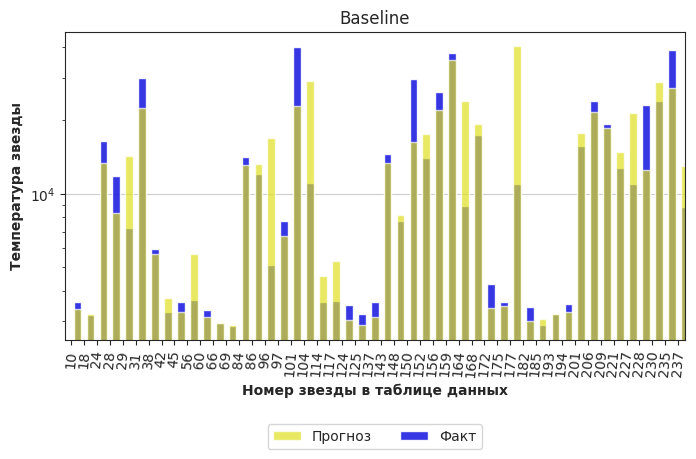

In [39]:
# строим график для визуализации предсказаний baseline модели
plot(y_test, test_outputs, 'Baseline')

## Улучшение модели

В задании к проекту нам дано обязательное требование
создать решение с перебором параметров нейросети:
- dropout
- размер батча.


Следующим этапом я проведу эксперимент с данными:
1.  создам синтетические данные и, обучив на них, получим предсказание на test выборке исходного датасета.
2. аугментирую исходный датасет (добавлю шум к числовым признакам) и, обучив на них, получим предсказание на test выборке исходного датасета.




### Dropout

In [40]:
class DropoutModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        super(DropoutModel, self).__init__()

        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5) # 50% dropout после первого слоя
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5) # 50% dropout после второго слоя

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)  #  Dropout после первого слоя
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)  #  Dropout после второго слоя

        return x

In [42]:
model = DropoutModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:

            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')


Epoch [1000/10000], Loss: 95735752.0
Epoch [2000/10000], Loss: 109357608.0
Epoch [3000/10000], Loss: 70501032.0
Epoch [4000/10000], Loss: 106643152.0
Epoch [5000/10000], Loss: 94354312.0
Epoch [6000/10000], Loss: 111140552.0
Epoch [7000/10000], Loss: 120358144.0
Epoch [8000/10000], Loss: 102239480.0
Epoch [9000/10000], Loss: 115443680.0
Epoch [10000/10000], Loss: 101702168.0


In [43]:
model.eval()  # оценка
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

In [44]:
rmse_dropout = np.sqrt(test_loss.item())
result.append(['rmse_dropout', rmse_dropout])
result

[['rmse_baseline', tensor(7392.8315)], ['rmse_dropout', 9483.592568220125]]

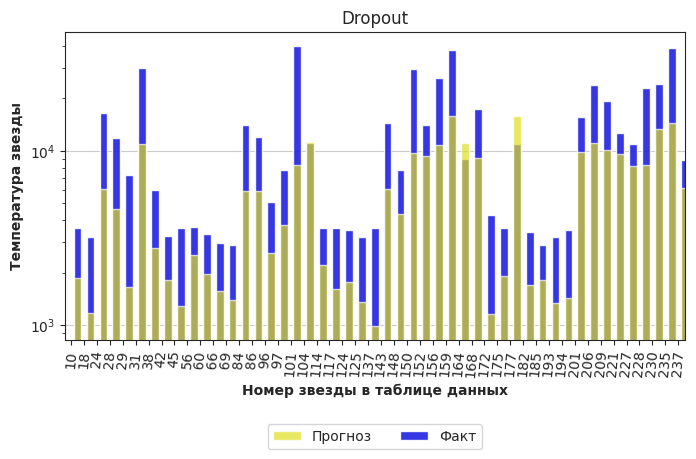

In [45]:
plot(y_test, test_outputs, 'Dropout')

#### Подбор параметра Dropout

In [ ]:
DropoutBestModel

In [ ]:
model = DropoutBestModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')


In [ ]:
model.eval()  # оценка
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

In [ ]:
rmse_best_dropout = np.sqrt(test_loss.item())
result.append(['rmse_dropout', rmse_dropout])
result

In [ ]:
plot(y_test, test_outputs, 'Dropout')

#### BatchNorm

In [46]:
class BatchNormModel(nn.Module):
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        super(BatchNormModel, self).__init__()
        self.fc1 = nn.Linear(input_neurons, hidden_neurons)
        self.bn1 = nn.BatchNorm1d(hidden_neurons)  # BatchNorm1d 1 слоя
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_neurons)
        self.bn2 = nn.BatchNorm1d(output_neurons)  # BatchNorm1d 2 слоя
        self.act2 = nn.ReLU()

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # BatchNorm после  слоя
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)  # BatchNorm после второго слоя
        x = self.act2(x)
        return x


In [47]:
model = BatchNormModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

        outputs = model(X_train)

        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')


Epoch [1000/10000], Loss: 195542464.0
Epoch [2000/10000], Loss: 195148912.0
Epoch [3000/10000], Loss: 194754944.0
Epoch [4000/10000], Loss: 194358928.0
Epoch [5000/10000], Loss: 193965568.0
Epoch [6000/10000], Loss: 193571104.0
Epoch [7000/10000], Loss: 193180224.0
Epoch [8000/10000], Loss: 192783568.0
Epoch [9000/10000], Loss: 192392128.0
Epoch [10000/10000], Loss: 191999664.0


In [48]:
model.eval()  # оценка
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

In [49]:
rmse_batchnorm = np.sqrt(test_loss.item())
result.append(['rmse_batchnorm', rmse_batchnorm])
result

[['rmse_baseline', tensor(7392.8315)],
 ['rmse_dropout', 9483.592568220125],
 ['rmse_batchnorm', 15578.189368472833]]

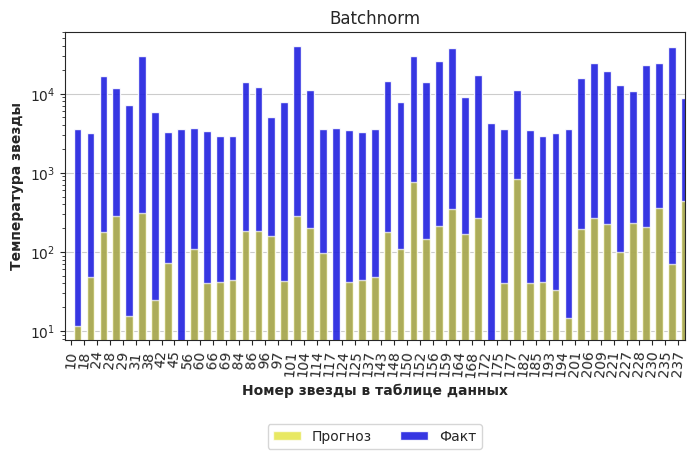

In [50]:
plot(y_test, test_outputs, 'Batchnorm')

### Аугментация данных

Метрику мы будем сравнивать на baseline модели, предсказывая по test выборке исходного датасета.

###Синтетическая Генерация Данных

Ниже приведена таблица с диапазонами характеристик для каждой звезды, мы будем создавать новые данные используя эту таблицу.

| Температура (K) | Светимость (L/Lo) | Радиус (R/Ro) | Абсолютная звёздная величина (Mv) | Тип звезды | Цвет звезды |
|-----------------|-------------------|---------------|------------------------------------|------------|-------------|
| ~2,000 K        | 0.00001% - 0.1%   | 0.1 - 0.7     | Высокая отрицательная              | M (красные карлики) | Красные, оранжевые |
| ~3,500 K        | 1% - 10%           | 0.7 - 1.0     | Низкая отрицательная               | K | Оранжевые, красные |
| Очень высокая  | Очень низкая       | Сравним с Землёй | Высокая отрицательная | Белые карлики | Белые |
| ~5,500 K        | 100%               | 1.0           | 4.83                               | G (похожие на Солнце) | Желтые |
| ~10,000 K - несколько десятков тысяч K | >100 - несколько тысяч | >1 - несколько сотен | Низкая отрицательная | Горячие звёзды | Голубые, белые |
| ~2,000 K - 1,000 K (обычно ниже) | Очень низкая - очень очень низкая | 0.01 - 0.1 (примерно) | Высокая отрицательная | Коричневые карлики | Коричневые |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Гиганты (разных классов) | Разноцветные |
| Разнообразная  | Очень высокая - низкая | Разнообразный | Разнообразная | Сверхгиганты | Разноцветные |
| ~5,500 K        | Около 100%         | Около 1.0     | 4.83 | Звёзды главной последовательности | Желтые |


In [200]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

In [93]:
100*0.45+100*0.008+100*0.041+100*0.008+100*0.17+100*0.35

80.0

In [ ]:
красных оранжевых белых

In [51]:
synthetic_data = []

n_samples = 200  # Общее количество сэмплов

# Генерация данных для красных карликов (M-тип)
n_samples_m = int(n_samples * 0.45)
temperature_m = np.random.uniform(2000, 3500, n_samples_m)
luminosity_m = np.random.uniform(0.00001, 0.1, n_samples_m)
radius_m = np.random.uniform(0.1, 0.7, n_samples_m)
magnitude_m = np.random.uniform(-11.92, -6.23, n_samples_m)
star_type_m = [0] * n_samples_m  # добавляем тип звезды (0-6)
star_color_m = ['red'] * n_samples_m

# Генерация данных для оранжевых карликов (K-тип)
n_samples_k = int(n_samples * 0.151)
temperature_k = np.random.uniform(3500, 5500, n_samples_k)
luminosity_k = np.random.uniform(0.01, 0.1, n_samples_k)
radius_k = np.random.uniform(0.7, 1.0, n_samples_k)
magnitude_k = np.random.uniform(-6.23, -2, n_samples_k)
star_type_k = [1] * n_samples_k
star_color_k = ['orange'] * n_samples_k

# Генерация данных для белых карликов (группа "Очень высокая")
n_samples_wd = int(n_samples * 0.16)
temperature_wd = np.random.uniform(5500, 6000, n_samples_wd)
luminosity_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
radius_wd = np.random.uniform(0.99, 1.01, n_samples_wd)
magnitude_wd = np.full(n_samples_wd, 4.83)
star_type_wd = [2] * n_samples_wd
star_color_wd = ['white'] * n_samples_wd

# Генерация данных для звёзд главной последовательности (G-тип)
n_samples_g = int(n_samples * 0.09)
temperature_g = np.random.uniform(5500, 5700, n_samples_g)
luminosity_g = np.random.uniform(0.99, 1.01, n_samples_g)
radius_g = np.random.uniform(0.99, 1.01, n_samples_g)
magnitude_g = np.full(n_samples_g, 4.83)
star_type_g = [3] * n_samples_g
star_color_g = ['yellow'] * n_samples_g

# Генерация данных для горячих звёзд
n_samples_hot = int(n_samples * 0.3)
temperature_hot = np.random.uniform(10000, 30000, n_samples_hot)
luminosity_hot = np.random.uniform(100, 3000, n_samples_hot)
radius_hot = np.random.uniform(10, 100, n_samples_hot)
magnitude_hot = np.random.uniform(-11.92, -6.23, n_samples_hot)
star_type_hot = [4] * n_samples_hot
star_color_hot = ['blue'] * n_samples_hot

# Генерация данных для коричневых карликов (L-тип)
n_samples_l = int(n_samples * 0.06)
temperature_l = np.random.uniform(1000, 2000, n_samples_l)
luminosity_l = np.random.uniform(0.00000001, 0.0000001, n_samples_l)
radius_l = np.random.uniform(0.01, 0.1, n_samples_l)
magnitude_l = np.random.uniform(-11.92, -6.23, n_samples_l)
star_type_l = [5] * n_samples_l
star_color_l = ['blue_white'] * n_samples_l

# создаем новый df
synthetic_data = pd.DataFrame({
    'temperature': np.concatenate((temperature_m,
                                   temperature_k,
                                   temperature_wd,
                                   temperature_g,
                                   temperature_hot,
                                   temperature_l)),

    'luminosity': np.concatenate((luminosity_m,
                                  luminosity_k,
                                  luminosity_wd,
                                  luminosity_g,
                                  luminosity_hot,
                                  luminosity_l)),

    'radius': np.concatenate((radius_m,
                              radius_k,
                              radius_wd,
                              radius_g,
                              radius_hot,
                              radius_l)),

    'magnitude': np.concatenate((magnitude_m,
                                 magnitude_k,
                                 magnitude_wd,
                                 magnitude_g,
                                 magnitude_hot,
                                 magnitude_l)),

    'star_type': np.concatenate((star_type_m,
                                 star_type_k,
                                 star_type_wd,
                                 star_type_g,
                                 star_type_hot,
                                 star_type_l)),

    'star_color': np.concatenate((star_color_m,
                                  star_color_k,
                                  star_color_wd,
                                  star_color_g,
                                  star_color_hot,
                                  star_color_l))
})

# перемешиваем
synthetic_data = synthetic_data.sample(frac=1).reset_index(drop=True)

In [52]:
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  202 non-null    float64
 1   luminosity   202 non-null    float64
 2   radius       202 non-null    float64
 3   magnitude    202 non-null    float64
 4   star_type    202 non-null    int64  
 5   star_color   202 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 9.6+ KB


In [53]:
synthetic_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,202.000000,2.020000e+02,202.000000,202.000000,202.000000
mean,9171.914649,4.783931e+02,14.523800,-5.004608,2.217822
std,8746.509710,8.662733e+02,25.024207,6.042506,1.708067
min,1124.297223,1.598466e-08,0.030899,-11.825615,0.000000
25%,3035.289371,5.428728e-02,0.584566,-9.883873,1.000000
50%,5538.757708,9.916761e-01,0.995056,-7.291337,2.000000
75%,13191.338546,5.187541e+02,20.837569,-2.116109,4.000000
max,29859.295922,2.999181e+03,92.878516,4.830000,5.000000


In [54]:
data['star_color'].value_counts(normalize = True)

red                   0.466667
blue                  0.233333
blue_white            0.170833
white                 0.041667
yellow_white          0.033333
yellowish_white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale_yellow_orange    0.004167
white_yellow          0.004167
orange_red            0.004167
Name: star_color, dtype: float64

#### модель на синт данных

In [55]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 97 to 168
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  48 non-null     int64  
 1   luminosity   48 non-null     float64
 2   radius       48 non-null     float64
 3   magnitude    48 non-null     float64
 4   star_type    48 non-null     int64  
 5   star_color   48 non-null     object 
dtypes: float64(3), int64(2), object(1)
memory usage: 2.6+ KB


In [56]:
train, valid = train_test_split(synthetic_data,
                                shuffle=True,
                                random_state = RANDOM_STATE)

print('Размер обучающей выборки',train.shape)

test = test

print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (151, 6)
Размер валидационной выборки (51, 6)

Размер тестовой выборки (48, 6)


In [57]:
column_transformer = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
     ('scale', StandardScaler(), numerical)])

X_train = torch.Tensor(column_transformer.fit_transform(train[X]))

X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())


torch.Size([151, 10])

torch.Size([51, 10])

torch.Size([48, 10])


In [61]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                      hidden_neurons,
                      output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [62]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()  # Перевести модель в режим оценки

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {test_loss.item()}')

Epoch [1000/10000], Loss: 130202792.0
Epoch [2000/10000], Loss: 65395576.0
Epoch [3000/10000], Loss: 26161014.0
Epoch [4000/10000], Loss: 16674874.0
Epoch [5000/10000], Loss: 15454523.0
Epoch [6000/10000], Loss: 14821112.0
Epoch [7000/10000], Loss: 14040103.0
Epoch [8000/10000], Loss: 13379233.0
Epoch [9000/10000], Loss: 12793808.0
Epoch [10000/10000], Loss: 12287446.0
Test Loss: 313192972288.0


In [63]:
rmse_synthetic = np.sqrt(test_loss.item())
result.append(['rmse_synthetic', rmse_synthetic])
result

[['rmse_baseline', tensor(7392.8315)],
 ['rmse_dropout', 9483.592568220125],
 ['rmse_batchnorm', 15578.189368472833],
 ['rmse_synthetic', 638091.1052193096],
 ['rmse_synthetic', 559636.4644016685]]

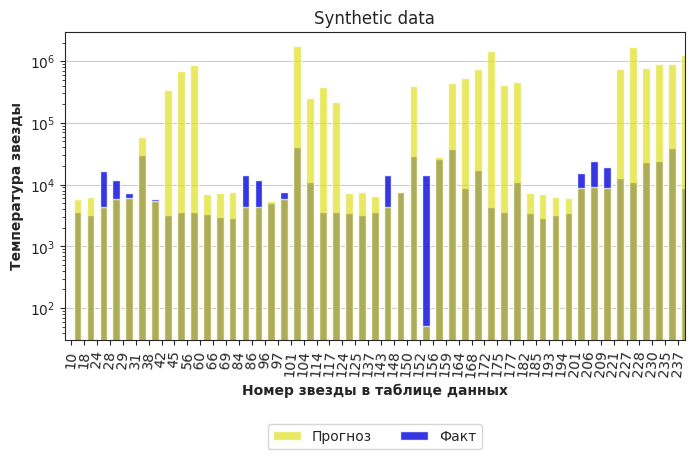

In [64]:
plot(y_test, test_outputs, 'Synthetic data')

### Аугментация данных на основе исходного датасета

In [65]:
numerical

['luminosity', 'radius', 'magnitude', 'star_type']

In [66]:
augmented_data = data.copy()

# числовые признаки, к которым добавляем шум
numeric_features = ['luminosity', 'radius', 'magnitude']

# значения шума
noise_mean = 0  # Среднее значение шума
noise_std = 0.05  # Стандартное отклонение шума

for numeric_feature in numeric_features:
    random_noise = np.random.normal(noise_mean, noise_std, len(data))
    augmented_data[numeric_feature] += random_noise

    # контролируем разброс min max значений
    augmented_data[numeric_feature] = np.clip(augmented_data[numeric_feature],
                                              data[numeric_feature].min(),
                                              data[numeric_feature].max())

# Создайте новый DataFrame для аугментированных данных
augmented_data.head()


,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.000080,0.173710,16.071540,0,red
1,3042,0.088734,0.142730,16.627552,0,red
2,2600,0.000080,0.149525,18.792331,0,red
3,2800,0.000080,0.142851,16.661114,0,red
4,1939,0.065926,0.128275,20.060000,0,red


In [67]:
augmented_data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.367751,237.163470,4.381116,2.500000
std,9552.425037,179432.238712,517.150005,10.532203,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.007056,0.127674,-6.273777,1.000000
50%,5776.000000,0.117467,0.739076,8.354293,2.500000
75%,15055.500000,198050.033131,42.713336,13.723127,4.000000
max,40000.000000,849420.000000,1948.404395,20.060000,5.000000


In [68]:
data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


####модель на аугментированном датасете с шумом

In [75]:
train, valid = train_test_split(augmented_data,
                                shuffle=True,
                                random_state = RANDOM_STATE)

print('Размер обучающей выборки',train.shape)
print()
print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)


Размер обучающей выборки (180, 6)

Размер валидационной выборки (60, 6)

Размер тестовой выборки (48, 6)


In [76]:
column_transformer = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
     ('scale', StandardScaler(), numerical)])

X_train = torch.Tensor(column_transformer.fit_transform(train[X]))

X_valid = torch.Tensor(column_transformer.transform(valid[X]))
X_test = torch.Tensor(column_transformer.transform(test[X]))


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())


torch.Size([180, 15])

torch.Size([60, 15])

torch.Size([48, 15])


In [77]:
input_neurons = X_train.shape[1]


model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

In [78]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()  # Перевести модель в режим оценки

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {np.sqrt(test_loss.item())}')

Epoch [1000/10000], Loss: 196771584.0
Epoch [2000/10000], Loss: 196771584.0
Epoch [3000/10000], Loss: 196771584.0
Epoch [4000/10000], Loss: 196771584.0
Epoch [5000/10000], Loss: 196771584.0
Epoch [6000/10000], Loss: 196771584.0
Epoch [7000/10000], Loss: 196771584.0
Epoch [8000/10000], Loss: 196771584.0
Epoch [9000/10000], Loss: 196771584.0
Epoch [10000/10000], Loss: 196771584.0
Test Loss: 15760.036040567928


In [79]:
rmse_augmented = np.sqrt(test_loss.item())
result.append(['rmse_augmented', rmse_augmented])
result

[['rmse_baseline', tensor(7392.8315)],
 ['rmse_dropout', 9483.592568220125],
 ['rmse_batchnorm', 15578.189368472833],
 ['rmse_synthetic', 638091.1052193096],
 ['rmse_synthetic', 559636.4644016685],
 ['rmse_concat2', 5257.020258663647],
 ['rmse_augmented', 15760.036040567928]]

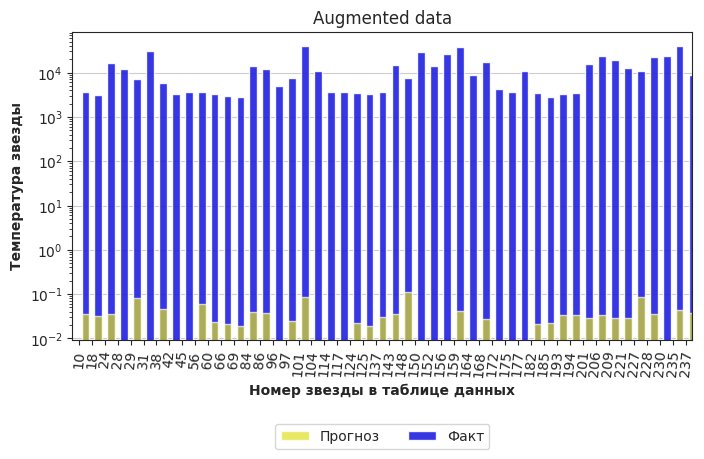

In [80]:
plot(y_test, test_outputs, 'Augmented data')

#### модель на 2-x датасетах

In [322]:
data_concat2 = pd.concat([augmented_data,
                          synthetic_data],
                         ignore_index = True)

In [323]:
train, valid = train_test_split(data_concat2,
                                shuffle=True,
                                random_state = RANDOM_STATE)
test = test
print('Размер обучающей выборки',train.shape)
print ()
print('Размер валидационной выборки', valid.shape)
print()
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (331, 6)

Размер валидационной выборки (111, 6)

Размер тестовой выборки (60, 6)


In [326]:
column_transformer = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
     ('scale', StandardScaler(), numerical)])

X_train = torch.Tensor(column_transformer.fit_transform(train[X]).toarray())
X_valid = torch.Tensor(column_transformer.transform(valid[X]).toarray())
X_test = torch.Tensor(column_transformer.transform(test[X]).toarray())


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([331, 17])

torch.Size([111, 17])

torch.Size([60, 17])


In [71]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()  # Перевести модель в режим оценки

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {test_loss.item()}')

Epoch [1000/10000], Loss: 23513376.0
Epoch [2000/10000], Loss: 19054552.0
Epoch [3000/10000], Loss: 17516344.0
Epoch [4000/10000], Loss: 16336181.0
Epoch [5000/10000], Loss: 15107940.0
Epoch [6000/10000], Loss: 14061962.0
Epoch [7000/10000], Loss: 12667544.0
Epoch [8000/10000], Loss: 11190436.0
Epoch [9000/10000], Loss: 9897009.0
Epoch [10000/10000], Loss: 8633448.0
Test Loss: 27636262.0


In [73]:
rmse_concat2 = np.sqrt(test_loss.item())
result.append(['rmse_concat2', rmse_concat2])
result

[['rmse_baseline', tensor(7392.8315)],
 ['rmse_dropout', 9483.592568220125],
 ['rmse_batchnorm', 15578.189368472833],
 ['rmse_synthetic', 638091.1052193096],
 ['rmse_synthetic', 559636.4644016685],
 ['rmse_concat2', 5257.020258663647]]

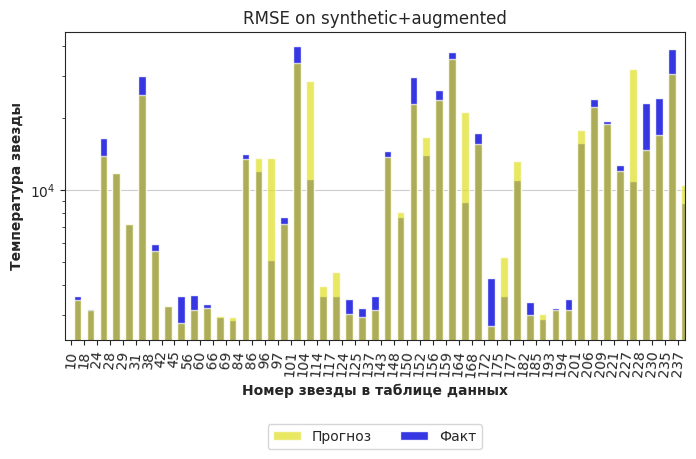

In [74]:
plot(y_test, test_outputs, 'RMSE on synthetic+augmented')

#### Модель на 3 датасетах

In [81]:
data_concat3 = pd.concat([data,
                          augmented_data,
                          synthetic_data],
                         ignore_index = True)

In [82]:
train, valid = train_test_split(data_concat3,
                                test_size = 0.4,
                                shuffle=True,
                                random_state = RANDOM_STATE)
print('Размер обучающей выборки',train.shape)

valid, test = train_test_split(valid,
                               test_size = 0.5,
                               shuffle=True,
                                random_state = RANDOM_STATE)

print('Размер валидационной выборки', valid.shape)
print( )
print('Размер тестовой выборки', test.shape)

Размер обучающей выборки (409, 6)
Размер валидационной выборки (136, 6)

Размер тестовой выборки (137, 6)


In [83]:
column_transformer = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical),
     ('scale', StandardScaler(), numerical)])


In [84]:
X_train = torch.Tensor(column_transformer.fit_transform(train[X]).toarray())
X_valid = torch.Tensor(column_transformer.transform(valid[X]).toarray())
X_test = torch.Tensor(column_transformer.transform(test[X]).toarray())


y_train = torch.Tensor(train[y].values).reshape(-1, 1)
y_valid = torch.Tensor(valid[y].values).reshape(-1, 1)
y_test = torch.Tensor(test[y].values).reshape(-1, 1)

print(X_train.size())
print()
print(X_valid.size())
print()
print(X_test.size())

torch.Size([409, 17])

torch.Size([136, 17])

torch.Size([137, 17])


In [87]:
input_neurons = X_train.shape[1]

model = BaselineModel(input_neurons,
                      hidden_neurons,
                      output_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [88]:
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()  # Перевести модель в режим оценки

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {test_loss.item()}')

Epoch [1000/10000], Loss: 23435022.0
Epoch [2000/10000], Loss: 17793686.0
Epoch [3000/10000], Loss: 15093848.0
Epoch [4000/10000], Loss: 13681098.0
Epoch [5000/10000], Loss: 13109697.0
Epoch [6000/10000], Loss: 12586746.0
Epoch [7000/10000], Loss: 12141110.0
Epoch [8000/10000], Loss: 11491884.0
Epoch [9000/10000], Loss: 10435781.0
Epoch [10000/10000], Loss: 9682566.0
Test Loss: 21071402.0


In [89]:
rmse_concat3 = np.sqrt(test_loss.item())
result.append(['rmse_concat3', rmse_concat3])
result

[['rmse_baseline', tensor(7392.8315)],
 ['rmse_dropout', 9483.592568220125],
 ['rmse_batchnorm', 15578.189368472833],
 ['rmse_synthetic', 638091.1052193096],
 ['rmse_synthetic', 559636.4644016685],
 ['rmse_concat2', 5257.020258663647],
 ['rmse_augmented', 15760.036040567928],
 ['rmse_concat3', 14400.39666120347],
 ['rmse_concat3', 4590.359680896477]]

In [ ]:
plot(y_test, test_outputs, 'RMSE on 3 datasets')

In [ ]:
y_test.numpy().flatten()

In [ ]:
test_outputs.numpy().flatten()

In [ ]:
# Данные для графика (fact_values и forecast_values должны быть определены заранее)
indexes = test[y].index[:48]
# Установка размера графика и стиля
plt.figure(figsize=(8, 4))
sns.set_style("ticks", {'axes.grid': True})

# Создание столбчатой диаграммы для фактических значений
fact_plot = sns.barplot(x = indexes,
                        y=fact_values,
                        color='#ade2f6',
                        alpha=0.9,
                        label='Факт')

# Создание столбчатой диаграммы для прогнозов
forecast_plot = sns.barplot(
    x=indexes,
    y=forecast_values,
    color='#fec000',
    alpha=0.7,
    label='Прогноз')

# Установка ширины столбцов и их позиции
bar_width = 0.4

for bar in fact_plot.patches + forecast_plot.patches:
    bar.set_width(bar_width)
    x = bar.get_x()
    bar.set_x(x + bar_width / 2)

# Установка подписей осей и заголовка
plt.xlabel("Номер звезды в таблице данных", fontweight='bold')
plt.ylabel("Температура звезды", fontweight='bold')
plt.title("Температура звезд")
plt.xticks(rotation=85)
plt.yscale('log')
# Создание и настройка легенды
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()
plt.legend(handles,
           labels,
           bbox_to_anchor=(0.5, -0.25),
           loc='upper center',
           ncol=2)

# Отображение графика
plt.show()


### Подбор гиперпараметров сети

In [ ]:
input_neurons = X_train.shape[1]
hidden_neurons = 300
output_neurons = 1

model = RegressionModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10000
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()  # Перевести модель в режим оценки

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {np.sqrt(test_loss.item())}')

Epoch [1000/10000], Loss: 195898144.0
Epoch [2000/10000], Loss: 195857664.0
Epoch [3000/10000], Loss: 195817552.0
Epoch [4000/10000], Loss: 195778528.0
Epoch [5000/10000], Loss: 195738560.0
Epoch [6000/10000], Loss: 195699104.0
Epoch [7000/10000], Loss: 195660192.0
Epoch [8000/10000], Loss: 195620160.0
Epoch [9000/10000], Loss: 195580752.0
Epoch [10000/10000], Loss: 195542448.0
Test Loss: 15741.83165962589


In [ ]:
rmse_batchnorm = np.sqrt(test_loss.item())
result.append(['rmse_batchnorm', rmse_batchnorm])
result

[['rmse_baseline', tensor(6463.2998)], ['rmse_batchnorm', 15741.83165962589]]

In [ ]:
input_neurons = X_train.shape[1]
hidden_neurons = 300
output_neurons = 1

model = RegressionModel(input_neurons,
                        hidden_neurons,
                        output_neurons)

loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10000
for epoch in range(num_epochs):

    outputs = model(X_train)

    # Вычисление потерь
    loss_train = loss(outputs, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

model.eval()

with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = loss(test_outputs, y_test)

print(f'Test Loss: {np.sqrt(test_loss.item())}')

Epoch [1000/10000], Loss: 167140272.0
Epoch [2000/10000], Loss: 139050128.0
Epoch [3000/10000], Loss: 114954072.0
Epoch [4000/10000], Loss: 139619392.0
Epoch [5000/10000], Loss: 129771480.0
Epoch [6000/10000], Loss: 136221776.0
Epoch [7000/10000], Loss: 89596176.0
Epoch [8000/10000], Loss: 136620112.0
Epoch [9000/10000], Loss: 108627144.0
Epoch [10000/10000], Loss: 121085152.0
Test Loss: 9897.521710003975


In [ ]:
rmse_dropout = np.sqrt(test_loss.item())
result.append(['rmse_dropout', rmse_dropout])
result

In [ ]:
def fit(model, X_train, y_train, X_test, y_test, num_epochs=10000, print_every=1000):
    optimizer = torch.optim.Adam(model.parameters())
    loss = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        outputs = model(X_train)

        # Вычисление потерь
        loss_train = loss(outputs, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

    model.eval()  # Перевести модель в режим оценки

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = loss(test_outputs, y_test)

    print(f'Test Loss: {np.sqrt(test_loss.item())}')


In [ ]:
dropout_values = [0.1, 0.3, 0.5]
batch_sizes = [32, 64, 128]

input_neurons = X_train.shape[1]
hidden_neurons = 300
output_neurons = 1

best_rmse = float('inf')
best_model = None
best_dropout = None
best_batch_size = None

num_epochs = 10000

# Определение функции потерь и оптимизатора
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam

for dropout in dropout_values:
    for batch_size in batch_sizes:
        # Создание и обучение модели
        model = RegressionModel(input_neurons, hidden_neurons, output_neurons)
        optimizer_instance = optimizer(model.parameters())

        for epoch in range(num_epochs):
            outputs = model(X_train)
            loss_train = loss(outputs, y_train)

            optimizer_instance.zero_grad()
            loss_train.backward()
            optimizer_instance.step()

            if (epoch + 1) % 1000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_train.item()}')

        # Оценка модели на тестовых данных
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss(test_outputs, y_test)

        # Оценка RMSE на тестовых данных
        rmse = np.sqrt(test_loss.item())

        # Сравнение RMSE с лучшим результатом
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_dropout = dropout
            best_batch_size = batch_size

# Вывод результатов
print(f"Лучший RMSE: {best_rmse}")
print(f"Лучшие параметры: Dropout = {best_dropout}, Batch Size = {best_batch_size}")


In [ ]:
# Вывод результатов
print(f"Лучший RMSE: {best_rmse}")
print(f"Лучшие параметры: Dropout = {best_dropout}, Batch Size = {best_batch_size}")


In [ ]:
rmse_dropout_batch_size = best_rmse
result.append(['rmse_concat3', rmse_dropout_batch_size])
result